In [1]:
!pip install transformers datasets accelerate bitsandbytes peft
!pip install sentencepiece torch torchvision torchaudio
!pip install huggingface_hub
!pip install langchain llama-index pypdf
!pip install -U langchain-community
!pip install langchain pypdf chromadb
!pip install sentence-transformers

In [2]:
import torch

torch.cuda.empty_cache()  # Clears unused memory
torch.cuda.ipc_collect()

In [3]:
!pip install peft

In [4]:
import pandas as pd

# Load the dataset
train_df = pd.read_csv('MATH_train_staging.csv')  # Update the path
val_df = pd.read_csv('MATH_val_staging.csv')
test_df = pd.read_csv('MATH_test_staging.csv')

# Check structure
print(train_df.head())
print(val_df.head())
print(test_df.head())


   dataset_id  question_id                                      question_text  \
0           2          427  Find the equation whose graph is a parabola wi...   
1           2         1594  If $f(x)=\sqrt{x-3}$, what is the smallest rea...   
2           2          806  Positive real numbers $r,s$ satisfy the equati...   
3           2          411  If $\log_{25}(x-4)=\frac{1}{2}$, find $\frac{1...   
4           2         6260  How many perfect squares are two-digit and div...   

                                              answer  \
0  Hence the answer to this question is $-3x^2+12...   
1         Hence the answer to this question is $12$.   
2          Hence the answer to this question is $1$.   
3          Hence the answer to this question is $2$.   
4          Hence the answer to this question is $2$.   

                                           reasoning  
0  Since the axis of symmetry is vertical and the...  
1  Note that $f(x)$ is defined if and only if $x\...  
2  We have 

In [5]:
train_df.rename(columns={'question_text': 'question', 'reasoning': 'chain_of_thought', 'answer': 'answer'}, inplace=True)
val_df.rename(columns={'question_text': 'question', 'reasoning': 'chain_of_thought', 'answer': 'answer'}, inplace=True)
test_df.rename(columns={'question_text': 'question', 'reasoning': 'chain_of_thought', 'answer': 'answer'}, inplace=True)

In [6]:
import json
from datasets import Dataset

def prepare_data(df):
    data = []
    for _, row in df.iterrows():
        data.append({
            "input": row["question"],
            "output": row["chain_of_thought"] + " " + row["answer"]
        })
    return data

# Convert CSV data into JSON structure
train_data = prepare_data(train_df)
val_data = prepare_data(val_df)
test_data = prepare_data(test_df)

# Save JSON files for future use
with open("train_data.json", "w") as f:
    json.dump(train_data, f, indent=4)
with open("val_data.json", "w") as f:
    json.dump(val_data, f, indent=4)
with open("test_data.json", "w") as f:
    json.dump(test_data, f, indent=4)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType
import torch

model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # Avoids padding errors

# Load model once, apply LoRA directly
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Apply LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=64,
    lora_dropout=0.2,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


trainable params: 2,179,072 || all params: 1,779,267,072 || trainable%: 0.1225


In [8]:
def tokenize_fn(example):
    # Build a single prompt + target string
    # (for causal-LM you can also concatenate input + output then create labels)
    model_input = tokenizer(
        example["input"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    with tokenizer.as_target_tokenizer():                       # old API
        target = tokenizer(
            example["output"],
            truncation=True,
            padding="max_length",
            max_length=512,
        )

    model_input["labels"] = target["input_ids"]                 # ← trainer looks for this
    return model_input

train_tok = train_dataset.map(tokenize_fn, batched=True, remove_columns=["input", "output"])
val_tok   = val_dataset.map(tokenize_fn,   batched=True, remove_columns=["input", "output"])

Map:   0%|          | 0/5988 [00:00<?, ? examples/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 1497/1497 [00:00<00:00, 3321.94 examples/s]


In [9]:
from transformers import (
    TrainingArguments, Trainer,
    DataCollatorForLanguageModeling
)
import os, datasets

# 0️⃣  make sure pad-token is set
tokenizer.pad_token = tokenizer.eos_token          # ≤ transformers 4.2 fix

# 1️⃣  tokenization fn – returns input_ids / attention_mask / labels
def tokenize_fn(batch):
    # encode the prompt
    prompt_enc = tokenizer(
        batch["input"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    # encode the target / answer
    target_enc = tokenizer(
        batch["output"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    prompt_enc["labels"] = target_enc["input_ids"]  # Trainer looks for this
    return prompt_enc

# 2️⃣  map over the datasets and REMOVE the original text columns
train_tok = train_dataset.map(tokenize_fn, batched=True,
                              remove_columns=["input", "output"])
val_tok   = val_dataset.map(tokenize_fn,   batched=True,
                            remove_columns=["input", "output"])

# 3️⃣  collator for causal-LM (no masked-LM)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# 4️⃣  training arguments that old APIs accept
args = TrainingArguments(
    output_dir="./deepseekr1",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,   # keep the keys we just created
    report_to="none",              # suppress WANDB warning
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,           # still OK in older releases
    data_collator=data_collator,
)

trainer.train()


Map: 100%|██████████| 1497/1497 [00:00<00:00, 4663.68 examples/s]
/tmp/ipykernel_3803/985881744.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,1.873800
20,1.866000
30,1.744800
40,1.720900
50,1.476300
60,1.821700
70,1.630300
80,1.496200
90,1.371200
100,1.535800


TrainOutput(global_step=14970, training_loss=0.7438682633554768, metrics={'train_runtime': 1896.5259, 'train_samples_per_second': 15.787, 'train_steps_per_second': 7.893, 'total_flos': 1.4218459446509568e+17, 'train_loss': 0.7438682633554768, 'epoch': 5.0})

In [10]:
from tqdm import tqdm
from transformers import GenerationConfig
import torch

# Make sure generation_config exists
model.generation_config = GenerationConfig.from_pretrained(model_id)

# Sample a couple of test instances
sample_test = test_dataset.select(range(2))   # first 2 rows
model.eval().to("cuda")

outputs = []
for question in tqdm(sample_test["input"]):
    # Build the prompt with <think> tag + original question
    prompt = f"{question}\n<think>"

    enc = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
    ).to("cuda")

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            max_new_tokens=300,
            do_sample=True,
            temperature=0.5,
            top_p=0.95,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.eos_token_id,  # silence warning
        )

    # decode the same variable we just produced
    decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    outputs.append(decoded)

# Show side-by-side
for q, gen, ref in zip(sample_test["input"], outputs, sample_test["output"]):
    print("\n---")
    print("Question:\n", q)
    print("\nGenerated:\n", gen)
    print("\nReference:\n", ref)


100%|██████████| 2/2 [00:15<00:00,  7.94s/it]


---
Question:
 How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?

Generated:
 How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?
<think>
Alright, so I need to figure out how many vertical asymptotes are in the graph of \( y = \frac{2}{x^2 + x - 6} \). Hmm, okay. Let me recall what a vertical asymptote is. If you remember correctly, it's where the function approaches infinity or negative infinity as \( x \) gets closer and closer to some value from either side.

So for rational functions like this one, which can be written as \( \frac{\text{polynomial}}{\text{another polynomial}} \), vertical asymptotes occur at the zeros of the denominator (where the denominator equals zero but the numerator doesn't; otherwise, there might just be an indeterminate form like \( \frac{0}{0} \)).

Therefore, my task here should involve finding all real solutions to the equation \( x^2 + x - 6 = 0 \).

Wait, let me make sure that understanding is correct be

In [11]:
import random
from tqdm import tqdm
from transformers import GenerationConfig

# Ensure generation config is set
model.generation_config = GenerationConfig.from_pretrained(model_id)

# Pick 1 random test example
idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[idx]  # dictionary with "input" and "output"

# Prepare prompt with <think> tag
input_text = f"""Question: {sample['input']}

<think>
"""

# Tokenize with attention_mask
inputs = tokenizer(
    input_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)
input_ids = inputs["input_ids"].to("cuda")
attention_mask = inputs["attention_mask"].to("cuda")

# Generate response
model.eval()
model.to("cuda")

with torch.no_grad():
    generated_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=500,
        do_sample=True,
        temperature=0.5,
        top_p=0.95,
        repetition_penalty=1.2
    )

decoded_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

#  Display result
print("\n---")
print(f"Question:\n{sample['input']}\n")
print(f"Generated Response:\n{decoded_output}\n")
print(f"Reference Answer:\n{sample['output']}\n")


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



---
Question:
If $a$ and $b$ are real numbers, $a^2b^3=\frac{32}{27}$, and $\frac{a}{b^3}=\frac{27}{4}$, what is $a+b$?

Generated Response:
Question: If $a$ and $b$ are real numbers, $a^2b^3=\frac{32}{27}$, and $\frac{a}{b^3}=\frac{27}{4}$, what is $a+b$?

<think>
Okay, so I've got this problem here where I need to find the value of \( a + b \) given two equations involving exponents. Let me write them down again:

1. \( a^2 b^3 = \frac{32}{27} \)
2. \( \frac{a}{b^3} = \frac{27}{4} \)

Hmm, both these equations have powers of \( a \) and \( b \). Maybe if I can express one variable in terms of another or manipulate these equations somehow.

Starting with equation 2 because it seems simpler; let's solve for \( a \).

From equation 2:
\[ \frac{a}{b^3} = \frac{27}{4} \]
Multiplying both sides by \( b^3 \):
\[ a = \frac{27}{4} b^3 \]

Alright, now we know that \( a \) is equal to some multiple of \( b^3 \). Let's substitute this into equation 1 to eliminate \( a \) and work only with \( 

In [12]:
import random
from tqdm import tqdm
from transformers import GenerationConfig

# Set generation config
model.generation_config = GenerationConfig.from_pretrained(model_id)

# Sample 50 random indices
indices = random.sample(range(len(test_dataset)), 50)

# Collect results
generated_outputs = []

model.eval()
model.to("cuda")

for idx in tqdm(indices):
    sample = test_dataset[idx]

    question = sample["input"]
    reference_reasoning = sample["output"]  # ✅ use this as ground truth

    # Prompt with <think> tag
    input_text = f"Question: {question}\n\n<think>\n"

    # Tokenize input
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    input_ids = inputs["input_ids"].to("cuda")
    attention_mask = inputs["attention_mask"].to("cuda")

    # Generate output
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=500,
            do_sample=True,
            temperature=0.5,
            top_p=0.95,
            repetition_penalty=1.2
        )

    decoded_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Store for evaluation
    generated_outputs.append({
        "question": question,
        "generated": decoded_output,
        "reference": reference_reasoning
    })

100%|██████████| 50/50 [10:42<00:00, 12.85s/it]


In [13]:
import evaluate

# Extract prediction & reference lists
predictions = [item["generated"] for item in generated_outputs]
references = [item["reference"] for item in generated_outputs]

# BLEU
bleu = evaluate.load("bleu")
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])

# ROUGE
rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references)

# METEOR
meteor = evaluate.load("meteor")
meteor_result = meteor.compute(predictions=predictions, references=references)

# chrF
chrf = evaluate.load("chrf")
chrf_result = chrf.compute(predictions=predictions, references=references)

# BERTScore
bertscore = evaluate.load("bertscore")
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")


ModuleNotFoundError: No module named 'evaluate'

In [15]:
# In a notebook cell:
!pip install --quiet --upgrade evaluate


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
import random, datasets
from datasets import Dataset
from transformers import GenerationConfig
import torch, evaluate
from tqdm.notebook import tqdm

N = 50
rand_idx = random.sample(range(len(test_dataset)), N)
eval_ds  = test_dataset.select(rand_idx)     # columns: "input", "output"
answers  = list(eval_ds["output"])           # ground-truth chain + final answer


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

def generate_one(prompt,
                 max_new=256,
                 temperature=0.7,
                 top_p=0.95,
                 seed=None,
                 sample=True):                 # ← new flag
    gcfg = GenerationConfig(
        do_sample=sample,
        temperature=max(1e-5, temperature),   # clamp to >0
        top_p=top_p,
        max_new_tokens=max_new,
        pad_token_id=tokenizer.eos_token_id,
    )
    if seed is not None:
        torch.manual_seed(seed)
    toks = tokenizer(prompt, return_tensors="pt").to(device)
    out_ids = model.generate(**toks, generation_config=gcfg)[0]
    return tokenizer.decode(out_ids, skip_special_tokens=True)


In [26]:
PROMPTS = dict(
    # 3.1 Chain-of-Draft
    cod=
"""<system>You are an expert food reasoner. Break the problem into VERY SHORT drafts (≤5 words each), then give the final answer.</system>

<question>{q}</question>
<draft>
""",

    # 3.2 Plain Chain-of-Thought (baseline for self-consistency)
    cot=
"""<system>Think step-by-step.</system>
<question>{q}</question>
<thought>
""",

    # 3.3 Tree-of-Thought (we’ll embed the root prompt; ToT search loop below)
    tot_root=
"""You are an agent who can think in branches.
Problem: {q}
Start with an initial thought.
""",

    # 3.4 GRPO: force pseudo-code blocks
    grpo=
"""<system>Where helpful, write python-like code blocks to compute intermediate results, then print the answer.</system>
Q: {q}
A:
""",
)


In [27]:
def run_cod(q):
    return generate_one(PROMPTS["cod"].format(q=q))


In [28]:
from collections import Counter

def run_self_consistency(q, K=10):
    samples = [
        generate_one(PROMPTS["cot"].format(q=q), seed=42+i)
        for i in range(K)
    ]
    # extract final line (after last newline) as the predicted answer
    finals = [s.strip().splitlines()[-1] for s in samples]
    return Counter(finals).most_common(1)[0][0]


In [29]:
def expand(node_text, n=2):
    return [generate_one(node_text + f"\nThought {i+1}:", seed=123+i)
            for i in range(n)]

def score(text):
    judge_prompt = text + "\nIs this answer correct? Answer yes or no."
    # greedy decode → sample=False, temperature ignored
    out = generate_one(judge_prompt,
                       max_new=5,
                       temperature=1.0,   # any value now OK
                       sample=False)       # ← deterministic
    return 1 if "yes" in out.lower() else 0

def run_tot(q):
    root = PROMPTS["tot_root"].format(q=q)
    level1 = expand(root, n=2)
    best1  = max(level1, key=score)
    level2 = expand(best1, n=2)
    best2  = max(level2, key=score)
    return best2.strip().splitlines()[-1]


In [30]:
def run_grpo(q):
    return generate_one(PROMPTS["grpo"].format(q=q))


In [31]:
from tqdm import tqdm
tech2func = dict(cod=run_cod,
                 selfc=run_self_consistency,
                 tot=run_tot,
                 grpo=run_grpo)

preds = {name: [] for name in tech2func}

for q in tqdm(eval_ds["input"]):
    for name, func in tech2func.items():
        preds[name].append(func(q))



  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(

100%|██████████| 50/50 [1:24:23<00:00, 101.26s/it][A


In [40]:
pip install -U transformers accelerate bitsandbytes


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [41]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch, math

JUDGE_ID = "HuggingFaceH4/zephyr-7b-beta"     # or any instruct model

judge_tok = AutoTokenizer.from_pretrained(JUDGE_ID, use_fast=True)
judge_mod = AutoModelForCausalLM.from_pretrained(
    JUDGE_ID,
    device_map="auto",
    torch_dtype=torch.float16,
    load_in_4bit=True,                       # bitsandbytes
)

judge_pipe = pipeline("text-generation",
                      model=judge_mod,
                      tokenizer=judge_tok,
                      batch_size=4,
                      max_new_tokens=32)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]
Device set to use cuda:0


In [42]:
JUDGE_SYSTEM = (
"Evaluate the chain-of-thought reasoning in the generated text compared to the reference. Assess whether the reasoning steps are logical, complete, and lead to the correct conclusion."
)

def single_score(pred, ref):
    prompt = (
        f"{JUDGE_SYSTEM}\n"
        f"Reference answer:\n{ref}\n\n"
        f"Candidate answer:\n{pred}\n\n"
        "Score:"
    )
    resp = judge_pipe(prompt, do_sample=False)[0]["generated_text"]
    # extract last integer
    try:
        score = int(resp.strip().split()[-1])
    except ValueError:
        score = 0
    # clamp to 0-10
    return max(0, min(10, score))

def g_eval_open(preds, refs):
    scores = [single_score(p, r) for p, r in zip(preds, refs)]
    return sum(scores) / len(scores)


In [43]:
from statistics import mean
import evaluate

bleu      = evaluate.load("bleu")
meteor    = evaluate.load("meteor")
rouge     = evaluate.load("rouge")
chrf      = evaluate.load("chrf")
bertscore = evaluate.load("bertscore")

def calc_all(pred_list, refs):
    bs = bertscore.compute(
        predictions=pred_list,
        references=refs,
        model_type="bert-base-uncased",
    )["f1"]

    return dict(
        bleu    = bleu.compute(predictions=pred_list,  references=refs)["bleu"],
        meteor  = meteor.compute(predictions=pred_list, references=refs)["meteor"],
        rougeL  = rouge.compute(predictions=pred_list,  references=refs)["rougeL"],
        chrf    = chrf.compute(predictions=pred_list,   references=refs)["score"],
        bert_f1 = mean(bs),
        g_eval  = g_eval_open(pred_list, refs)          # ← local judge
    )


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [45]:
results = {name: calc_all(ps, answers) for name, ps in preds.items()}

/opt/conda/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [46]:
import pandas as pd

leader = (pd.DataFrame(results)          # rows = technique, cols = metrics
            .T                          # transpose so each technique is a row
            .loc[:, ["g_eval", "bert_f1", "bleu", "meteor", "rougeL", "chrf"]]
            .round(4)                   # 4-decimal precision
            .sort_values("g_eval", ascending=False))

print(leader.to_string())


       g_eval  bert_f1    bleu  meteor  rougeL     chrf
tot      0.40   0.4472  0.0000  0.0321  0.0703   3.0540
cod      0.16   0.6165  0.1240  0.2478  0.2054  30.3199
grpo     0.10   0.6661  0.1708  0.3062  0.2409  33.6753
selfc    0.04   0.4457  0.0000  0.0336  0.0660   4.3252


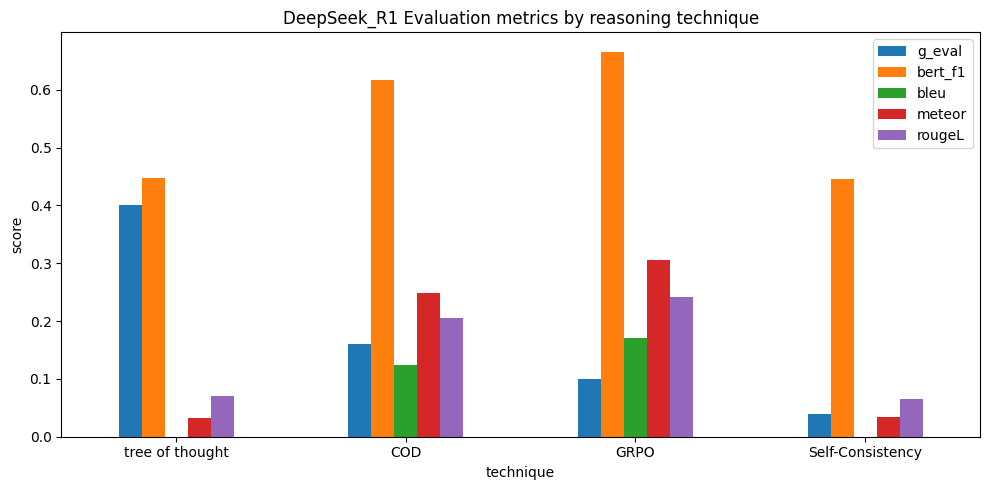

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# recreate the table you printed
data = {
    "technique": ["tree of thought", "COD", "GRPO", "Self-Consistency"],
    "g_eval":    [0.40, 0.16, 0.10, 0.04],
    "bert_f1":   [0.4472, 0.6165, 0.6661, 0.4457],
    "bleu":      [0.0, 0.1240, 0.1708, 0.0],
    "meteor":    [0.0321, 0.2478, 0.3062, 0.0336],
    "rougeL":    [0.0703, 0.2054, 0.2409, 0.0660],
}
df = pd.DataFrame(data).set_index("technique")

# plot grouped bar-chart
ax = df.plot.bar(figsize=(10, 5))
ax.set_ylabel("score")
ax.set_title("DeepSeek_R1 Evaluation metrics by reasoning technique")
ax.set_xticklabels(df.index, rotation=0)

plt.tight_layout()
